# 1 -Introduction

Nama: Ikhbar Firman Hanafi

Batch: 14

Phase: 2

URL: https://frontend-ikhbarp2ml2.herokuapp.com/

## Dataset

Dataset yang digunakan ini merupakan data dari IMDB movie review dari berbagai tahun yang mengandung atribut kolom informasi berikut:

- review_id:	It is generated by IMBb and unique to each review
- reviewer:	Public identity or username of the reviewer
- movie:	It represents the name of the show (can be - movie, tv-series, etc.)
- rating:	Rating of movie out of 10, can be None for older reviews
- review_summary:	Plain summary of the review
- review_date:	Date of the posted review
- spoiler_tag:	If 1 = spoiler & 0 = not spoiler
- review_detail:	Details of the review
- helpful:	list[0] people find the review helpful out of list[1]

Data source: https://www.kaggle.com/datasets/ebiswas/imdb-review-dataset

## Objective

Dari dataset ini, akan dilakukan sentiment analysis, dimana sentiment review diklasifikasikan menjadi positive, neutral dan negative sentiment berdasarkan rating.

Kemudian akan dilakukan prediksi sentiment berdasarkan input text review saja.

# 2 - Import Libraries

Kita akan import berbagai libraries yang diperlukan sebagai berikut.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding
from tensorflow.keras.layers import Dense, Input, LSTM, GRU, Dropout,BatchNormalization, Concatenate
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
import pickle

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 3 - Data Loading

Kita akan coba load data file json yang dikemas dalam zip dari:
 https://www.kaggle.com/datasets/ebiswas/imdb-review-dataset

In [2]:
#! pip install -q kaggle

#from google.colab import files

#files.upload()

In [3]:
# Make directory named kaggle and copy kaggle.json file there.

#! mkdir ~/.kaggle
#! cp kaggle.json ~/.kaggle/

In [4]:
#! chmod 600 ~/.kaggle/kaggle.json #Change the permissions of the file.

In [5]:
#!kaggle datasets download -d ebiswas/imdb-review-dataset --unzip

Terdapat 6 file dan saya akan load salah satu file saja, dikarenakan size tiap file json yang cukup besar (sekitar 1GB untuk tiap json file). Sehingga akan menyita banyak memory yang tersimpan dan juga pada proses neural network tensorflow yang memerlukan cukup memory.

In [2]:
data = pd.read_json('part-01.json').sample(35000, random_state=27)
data.head() # Menampilkan 5 baris data pertama

,review_id,reviewer,movie,rating,review_summary,review_date,spoiler_tag,review_detail,helpful
299764,rw5549191,acutabovegreencare,All's Faire in Love (2009),9.0,An awesome b movie,14 March 2020,0,A fun silly movie. It gets funnier every time ...,"[0, 0]"
713610,rw2953745,Anurag-Shetty,Frozen (I) (2013),9.0,The best animated movie of the year!,2 February 2014,0,"Frozen is a movie about two sisters, Anna(Kris...","[3, 8]"
191355,rw5533524,SayeemShams95,Good Newwz (2019),8.0,Entertaining!,7 March 2020,0,"Despite of the thin plot line, this film was a...","[1, 2]"
522716,rw6341981,frankdistefano,Mank (2020),2.0,MANK STANK,6 December 2020,0,"Dramatically inert, confusing and boring. Too ...","[6, 13]"
147017,rw1999018,bob the moo,The King of Kong: A Fistful of Quarters (2007),NaN,Really great quirkumentary that is entertainin...,31 December 2008,0,If there is a genre that I love when it is don...,"[2, 2]"


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35000 entries, 299764 to 359055
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   review_id       35000 non-null  object 
 1   reviewer        35000 non-null  object 
 2   movie           35000 non-null  object 
 3   rating          33205 non-null  float64
 4   review_summary  35000 non-null  object 
 5   review_date     35000 non-null  object 
 6   spoiler_tag     35000 non-null  int64  
 7   review_detail   35000 non-null  object 
 8   helpful         35000 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 2.7+ MB


Dari keterangan di atas, dataset mempunyai 35000 data points. Terdapat berbagai features dengan type integer pada **spoiler_tag** dan real number (float) pada rating dan sisanya berupa object string.

Adapun dari keterangan di atas terdapat missing value pada feature **rating**. Hal tersebut mungkin karena banyak reviewer yang memberikan review tanpa memberi rating.

Pada dataset feature **review_date** tertulis dengan type object, kita akan coba ubah dalam format timestamp.

In [4]:
data.review_date = pd.to_datetime(data.review_date) #Ubah string date time ke timestamp
data.sort_values('review_date')

,review_id,reviewer,movie,rating,review_summary,review_date,spoiler_tag,review_detail,helpful
995767,rw0965724,mattvc,Army of One (2003),8.0,Excellent portrait of what it's like to join t...,2004-11-17,0,Producer Sarah Goodman somehow talked the US A...,"[6, 7]"
995886,rw0965872,pizza0,Pom Poko (1994),9.0,Masterpiece!,2004-11-17,0,Pom Poko is about a bunch of raccoon-like anim...,"[9, 15]"
995680,rw0965627,briscoe-1,Megalodon (2002 Video),7.0,A shallow thriller/horror movie that could hav...,2004-11-17,0,A typical low budget thriller/horror movie wit...,"[3, 9]"
995748,rw0965701,Zeusboy23,Kin (I) (2004),7.0,A pretty solid short with some memorable moments,2004-11-17,0,"This film is a semi-campy look at the ""horrors...","[0, 0]"
996071,rw0966083,ramboski2003,Beverly Hills Cop (1984),NaN,awesome,2004-11-18,0,I'm not the biggest fan of cop movies but this...,"[1, 3]"
...,...,...,...,...,...,...,...,...,...
992591,rw6453034,TheOneThatYouWanted,Bill & Ted Face the Music (2020),3.0,Even Bill and Ted need a good plot to work off of,2021-01-08,0,It was nice to see Bill and Ted together again...,"[0, 0]"
992813,rw6453275,sabrina_2004,Tough As Nails (2020– ),10.0,Anyone can do anything...,2021-01-08,0,A tribute to the hard working class in America...,"[0, 0]"
994560,rw6455257,jplacerdasilva,Breadwinners (2014–2016),10.0,Hilarious!,2021-01-08,0,"This show is really good, but no one cares abo...","[0, 0]"
994115,rw6454737,mossikukulas-21314,Ghost in the Shell (1995),7.0,Great but It feels incomplete,2021-01-08,0,"I'm a big anime fan, big is an understatement ...","[0, 0]"


Dari sample dataset disini terdapat 35000 review movie dari tahun 2004 hingga 2021.

Kita coba cek data yang memiliki missing value rating.

In [5]:
data[data.isnull().any(axis=1)]

,review_id,reviewer,movie,rating,review_summary,review_date,spoiler_tag,review_detail,helpful
147017,rw1999018,bob the moo,The King of Kong: A Fistful of Quarters (2007),NaN,Really great quirkumentary that is entertainin...,2008-12-31,0,If there is a genre that I love when it is don...,"[2, 2]"
895394,rw2994621,bob the moo,It's Not You It's Me (2013),NaN,Darkly funny and punchy in how quickly it esca...,2014-04-08,0,This little comedy short is quite dark but app...,"[1, 1]"
446766,rw6238128,Rebekahjanel,50 First Dates (2004),NaN,Cute rom com,2020-11-05,0,Delightful pairing of Sandler and Barrymore. G...,"[0, 1]"
829973,rw2976696,ohashmawi,The Social Network (2010),NaN,"Amazing film, great performances, script and o...",2014-03-09,0,"So, The Social Network. This movie is incredib...","[0, 0]"
257109,rw5321490,deickemeyer,The War of the Wild (1915),NaN,Wellington A. Playter makes his first appearance,2019-12-14,0,"A two-reel jungle story, featuring lions, leop...","[0, 0]"
...,...,...,...,...,...,...,...,...,...
159716,rw3428457,Michael_Elliott,'Dune': Special Effects (2006 Video),NaN,The Effects of Dune,2016-03-08,0,Dune FX (2006) *** (out of 4)This here is one ...,"[1, 1]"
23458,rw2482394,dan.adams,The Wind and the Lion (1975),NaN,Where was the Lone Ranger?,2011-09-01,0,Great scenery-but there it ends.The sound was ...,"[0, 3]"
703221,rw6365242,EclecticEnnui,A Recipe for Seduction (2020 TV Short),NaN,Finger lickin' good,2020-12-14,0,I don't know if I've ever seen a film that's p...,"[4, 5]"
374110,rw5559846,wetmars,The Flash: The Exorcism of Nash Wells (2020) S...,NaN,The Curse of the Reverse Flash,2020-03-18,1,Eva sets Iris and her new mirror doppelganger ...,"[5, 5]"


Terdapat sejumlah 1795 datapoints dengan missing value **rating**. Kita tidak bisa melakukan imputasi value rating secara instant, dan hal yang sulit pula dilakukan meskipun kita menebak rating berdasarkan **review_detail** pada tiap baris data tersebut. Karena dataset yang kita miliki cukup besar, maka kita akan remove dari data untuk analisa berikutnya.

Selanjutnya kita akan hilangkan data yang tidak memiliki rating tersebut dari dataset, dan melakukan reset index.

In [6]:
data.dropna(inplace=True)
data.reset_index(drop=True,inplace=True) #reset index data

Dataset ini tidak memiliki feature yang merepresentasikan sentiment dari review. Namun disini saya akan mengklasifikasikan sentiment berdasarkan rating review, yang sebagaimana diterapkan pada penilitian yang dilakukan oleh Chaitanya Kulkarni dkk. Dimana sentiment positive untuk review dengan rating diatas atau sama dengan 7, rating 5 atau 6 termasuk neutral, sedangkan review dengan rating dibawah atau sama dengan 4 adalah negative.

Sumber: https://chaitanya1731.github.io/img/prj-1/report.pdf


Kita dapat mengkonversi rating ke sentimen sesuai aturan yang telah dibahas dengan menerapkan function berikut.

- Positive sentiment: 1
- Neutral sentiment: 0
- Negative sentiment: -1

In [7]:
# Membuat sentiment berdasarkan rating
def rating_sent(x):
    if x <=4: 
        return -1 # Negative sentiment
    elif (x==5) | (x==6): # Neutral sentiment
        return 0
    else: return 1 # Positive sentiment

Kita apply function di atas pada dataset.

In [8]:
data['sentiment'] = data['rating'].apply(lambda x: rating_sent(x))

In [9]:
data.sentiment.value_counts() #Melihat jumlah data untuk tiap sentiment

 1    20238
-1     8406
 0     4561
Name: sentiment, dtype: int64

Dapat dilihat di atas jumlah data tiap jenis sentiment. Data dengan positive sentiment memiliki jumlah terbanyak yaitu 20238 dan neutral sentiment dengan jumlah data terkecil yaitu 4561. 

Mengingat feature sentiment ini yang akan kita jadikan target output, maka dapat dikatakan dataset ini tergolong *imbalanced data* karena jumlah porsi yang sangat berbeda untuk tiap kelas target. Oleh karena itu kita akan mengambil sebagian sample dari tiap sentiment untuk analisis berikutnya.

Dikarenakan keterbatasan memory dan storage space, maka disini saya mengambil 4500 sample untuk tiap sentiment (dengan menyesuaikan jumlah data terkecil yaitu sentiment neutral), sehingga ada 13500 sample yang diambil.

In [10]:
#Mengambil sample data untuk tiap value sentiment

pos_sample = data[data.sentiment == 1].sample(4500, random_state=27)
neg_sample = data[data.sentiment == -1].sample(4500,random_state=27)
ntr_sample = data[data.sentiment == 0].sample(4500,random_state=27)

data_ready = pd.concat([pos_sample,neg_sample,ntr_sample],axis=0) #Menggbungkan (concat) tiap sample masing-masing sentiment
data_ready.head()

,review_id,reviewer,movie,rating,review_summary,review_date,spoiler_tag,review_detail,helpful,sentiment
46,rw5376645,Doasnow95,Don't F**k with Cats: Hunting an Internet Kill...,8.0,Good but traumatizing,2020-01-03,1,Ever since I watched it I wish I hadn't becaus...,"[4, 6]",1
2837,rw2889679,suendiana,Changing Rooms (1997–2004),10.0,I miss Changing Rooms . . . .,2013-10-19,0,I use to watch each & every show that aired of...,"[1, 1]",1
25504,rw5790285,damorejj,The History of Time Travel (2014),8.0,Very original,2020-06-01,1,If you don't understand how time travel works ...,"[0, 2]",1
2276,rw5154863,joelwatchesmovies,星際救援 (2019),7.0,Doesn't quite reach the depths or heights it's...,2019-10-01,0,"The at times brooding, at times exciting, but ...","[1, 3]",1
19627,rw5910397,joker-86842,Matriarch (I) (2018),9.0,Nightmare of a movie (especially if you're exp...,2020-07-16,0,This is a bit of an old fashioned horror movie...,"[4, 6]",1


Untuk mempermudah analisis ke depannya, disini saya juga akan reset index data.

In [11]:
data_ready.reset_index(drop=True, inplace=True) # reset index

# 4 - Exploratory Data Analysis (EDA)

Sebagaimana kita ketahui jumlah data ada sebanyak 13500 dan terdapat 4500 data untuk tiap sentiment.

- Positive sentiment: 1
- Neutral sentiment: 0
- Negative sentiment: -1

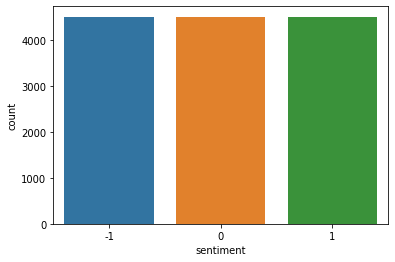

In [12]:
sns.countplot(x ='sentiment',data=data_ready)

Selanjutnya kita coba cek distribusi rating berdasarkan sentiment.

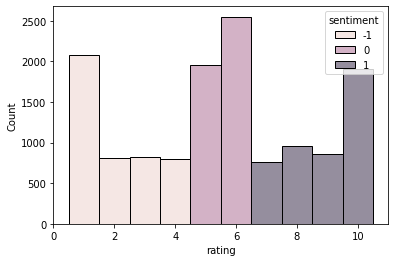

In [13]:
sns.histplot(x='rating',data=data_ready, hue='sentiment', discrete=True)

karena sebelumnya kita telah mengelompokkan sentiment berdasarkan rating, maka terlihat untuk sentiment neutral memiliki rating terbanyak 6 sekitar hampir 2500 data. Untuk sentiment negative memiliki rating terbanyak 1 sekitar 2000 data, dan untuk positive sentiment dengan rating terbanyak 10 sekitar hampir 2000 data.

Kita coba cek jumlah data untuk tiap tahun pada dataset

In [14]:
data_ready['review_year'] = pd.DatetimeIndex(data_ready['review_date']).year #Extract year from timestamp review_date

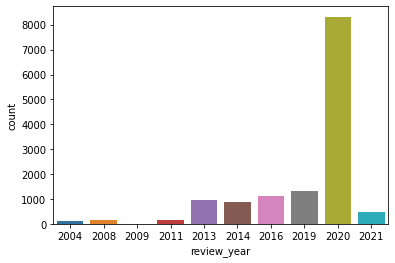

In [15]:
sns.countplot(x='review_year',data=data_ready)

Dari sini kita bisa mengetahui dataset memiliki jumlah review terbanyak pada tahun 2020, sedangkan sangat sedikit jumlah review tahun 2009 pada dataset.

Selanjutnya kita coba tampilkan 10 movie yang paling banyak direview dalam dataset ini.

In [16]:
data_ready.movie.value_counts()[:10]

Wonder Woman 1984 (2020)                               120
Laxmii (2020)                                           98
STAR WARS：天行者的崛起 (2019)                                 87
Dil Bechara (2020)                                      69
Coolie No. 1 (2020)                                     61
小丑 (2019)                                               58
Tenet (2020)                                            55
Batman v Superman: Dawn of Justice (2016)               53
Supernatural: Carry On (2020) Season 15, Episode 20     50
Mulan (2020)                                            47
Name: movie, dtype: int64

Kita dapat ketahui bahwa movie Wonder Woman 1984 (2020) paling banyak direview sebanyak 128 kali.

Selanjutnya ktia coba cek distribusi dari jumlah banyaknya kata dalam suatu review.

Mean jumlah kata dalam review: 149.67207407407406


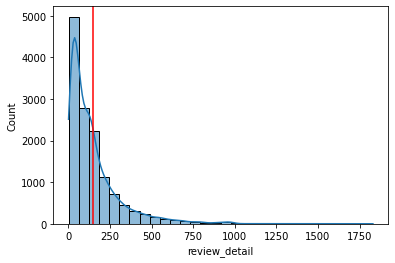

In [17]:
num_word_review = data_ready.review_detail.apply(lambda x: len(x.split(' '))) #Banyaknya kata untuk tiap review
sns.histplot(num_word_review, bins=30,kde=True) #Menampilkan histogram untuk banyaknya kata dalam review
plt.axvline(np.mean(num_word_review),color='red') # Menampilkan garis vertikal untuk mean
print('Mean jumlah kata dalam review:',np.mean(num_word_review))

Pada data set terlihat kebanyakan review mengandung jumlah kata kisaran dibawah 100 dengan rata-rata jumlah kata dalam suatu review movie adalah sekitar 149. Dari gambar diatas juga terdapat suatu review yang sangat panjang hingga mencapai 1500 kata.

In [18]:
print(data_ready.review_detail[num_word_review == max(num_word_review)].values) #Menampilkan review terpanjang pada dataset

['Here we have the "BET Awards 2019" and this title is fairly telling because there you see three major factors: This is from the television station BET. It is an awards show (barely, I swill get to that later) and it aired in 2019. In summer 2019, to be more precise, so this is from last year when it was still possible to have these ceremonies with big crowds as there was not an apparent global pandemic going on. Forst things first: This ran for three hours and thirty minutes (including commerccials), so it was like approximately Oscar running time. Extremely long. And extremely bland. With out commercials, it ran for "only" two hours and fourty minutes, but still incredibly long nonetheless. One of the directors is the eternal Glenn Weiss (so many Emmy wins) and he seems to be a regular with this show too despite his name and color. I guess this is the one area where they are making an exception. It\'s not as if anybody sees him anyway. I will spare you the names of the other directo

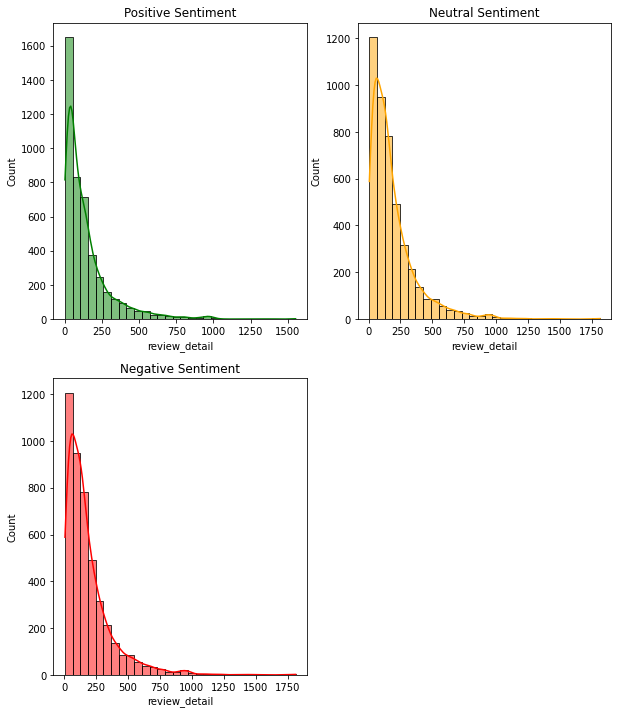

In [19]:
plt.figure(figsize=(10,12))
plt.subplot(2,2,1)
sns.histplot(num_word_review[data_ready.sentiment == 1],color='green',kde=True, bins=30)
plt.title('Positive Sentiment')

plt.subplot(2,2,2)
sns.histplot(num_word_review[data_ready.sentiment == 0],color='orange',kde=True, bins=30)
plt.title('Neutral Sentiment')

plt.subplot(2,2,3)
sns.histplot(num_word_review[data_ready.sentiment == 0],color='red',kde=True, bins=30)
plt.title('Negative Sentiment')
plt.show()

Berdasarkan distribusi jumlah kata untuk tiap sentiment, tidak terlihat suatu perbedaan yang jauh antar tiap sentiment. Proporsi jumlah kata review terbesar sekitar dibawah 200 kata untuk tiap sentiment dan berdasarkan bentuk histogramnya dapat dikatakan ketiga distribusi termasuk right-skewed

# 5 - Data Preprocessing

## Text processing

Sebelum dilakukan model prediksi sentiment, saya akan memproses data text **review_detail** yang sekiranya dapat membantu performa model. Adapun beberapa proses antara lain:

- Menghilangkan *stop words* seperti 'the', 'a', 'is' yang akan banyak dijumpai pada tiap kalimat, dan kata-kata tersebut tidak mencerminkan sentiment.
- Menghilangkan berbagai simbol dan angka dikarenakan alasan yang sama bahwa tidak mencerminkan sentiment kalimat. Meskipun angka pada review bisa jadi berperan dalam sentiment, namun terlihat tidak sering dijumpai.
- Mengubah tiap kata menjadi lower-case. Karena kata yang sama namun dengan perbedaan huruf besar kecil akan terdeteksi sebagai vocab yang berbeda, sehingga akan semakin banyak vocab yang dihasilkan. Hal tersebut akan membuat data yang dihasilkan ke dalam model menjadi lebih besar, sehingga lebih memakan cost dan tidak membantu performa.
- Menghilangkan simbol (punctuations) seperti "!", "?", "/", dsbnya serta menghilangkan adanya spasi ("\n"). Karena simbol tersebut dirasa tidak mencerminkan sentiment review.
- Menghilangkan kata berbentuk HTML seperti http.. dan www.. serta hashtags. Karena bisa jadi terdapat beberapa review yang mengandung link HTML dimana bentuk tersebut juga tidak perlu dalam mencerminkan sentiment.
- Melakukan stemming dan lemmatization. Dimana stemming word disini akan memangkas kata-kata menjadi serupa kata dasar. Contohnya 'loved' setelah dilakukan stemming akan menjadi 'love'. Sedankgan lemmatization kurang lebih serupa dalam hal menjadikan kata dasar, namun kata yang dihasilkan akan tetap memiliki konteks dari sudut pandang kita membaca. Contohnya kata 'studies' akan menjadi 'study'. Jadi stemming pada dasarnya hanya memotong beberapa huruf, sedangkan lemmatization tidak. Kita akan coba menijau contoh hasil dari lemmatization dan stemming lalu kita akan terapkan salah satu saja untuk proses berikutnya.

In [20]:
# cek review mengandung link berupa tags
tags_ = []
for i in data_ready.review_detail:
  tags_.append('#' in i)
data_ready.review_detail[tags_].iloc[0]

"Movie depicts the value of life in a humorous way. Yogi babu's counters are as usual great and funny.#senkettru's rating -10/10."

In [21]:
# cek review mengandung link berupa http
http = []
for i in data_ready.review_detail:
  http.append('http' in i)
data_ready.review_detail[http].iloc[0]

'Read More @ The Awards Circuit (http://www.awardscircuit.com)One of the things that have been thrown around for months now is the notion that awards season voting bodies won\'t respond to it because it\'s too "difficult" to sit through. Let\'s define difficult, shall we? Is it difficult to see the first openly gay politician gunned down by his closeted colleague? Is it difficult to see a reformed convict put to death by our country for his crimes? Is it difficult to see a mother choose which one of her children dies during the Holocaust? I\'d argue that these answers add up to a resounding yes. Yet, no one threw those phrases of "too difficult" around.I\'ve watched hundreds of films throughout my short 29-year history and I\'ve seen some difficult cinema. Steven Spielberg\'s "Schindler\'s List" can make anyone quiver in shame as it shows the despicable reality of the Holocaust. Paul Greengrass\' "United 93", which is almost an emotional biopic of America\'s darkest hour, makes me want

In [22]:
# cek review mengandung mention
mention_ = []
for i in data_ready.review_detail:
  mention_.append('@' in i)
data_ready.review_detail[mention_].iloc[4]

'I typically don\'t see horror or suspenseful movie but made an exception given the positive buzz and reviews. (My daughters and wife playfully tease me because of my unease with this movie genre.) Terror can be displayed in many forms. The subtle terror of much of The Invisible Man, where the antagonist is lurking but hidden, or may not be there at all, is executed brilliantly. Elizabeth Moss does a stellar job carrying the movie. She has learned to communicate effectively without words. Her ability to convey myriad emotion through facial expression, learned well from her time on the cast of The Handmaid\'s Tale, effectively translates to the big screen in this novel adaption of this classic story.Leigh Whannell does well building tension throughout the movie. The successful integration of sound and music adds to the palpable terror felt by the movie goers and enhances Elizabeth Moss\'s portrayal of a shattered person.There are a few big, plot gaps that made the movie more unrealistic

Kita bisa melihat terdapat suatu link "http", mention dan hashtag pada beberapa review tersebut. Dan terdapat beberapa kata seperti it\'s, could\'ve, they\'re yang akan kita coba handle.

Pertama kita akan coba definisikan stop words dari **gensim**, stemmer dengan **PorterStemmer** dan lemmatization dengan **WordNet Lemmatizer**.

In [23]:
stop_words = list(STOPWORDS)
stemmer = PorterStemmer()
lemma = WordNetLemmatizer()

Selanjutnya berbagai processing text yang sudah diutarakan sebelumnya dapat menggunakan function berikut.

In [24]:
def text_processing_1(text):
  text = text.lower() #Set lowercase pada kata
  text = re.sub("@[A-Za-z0-9_]+"," ", text) #Menghilangkan mention
  text = text.translate(str.maketrans(" "," ",string.punctuation)) #Menghilangkan punctuation
  text = re.sub(r"http\S+", " ", text) #Menghilangkan link
  text = re.sub(r"www.\S+", " ", text) #Menghilangkan link
  text = re.sub(r"\n"," ",text) #Menghilangkan \n
  text = text.strip() #Menghilangkan spasi kosong ataupun tab pada awal dan akhir kalimat
  text = re.sub("[^A-Za-z\s']"," ", text) #Menghilangkan yang bukan huruf
  tokens = word_tokenize(text) # Mendeteksi token pada kalimat
  text = [stemmer.stem(word) for word in tokens if word not in stop_words] #Stemming
  text = ' '.join(text)
  return text

In [25]:
def text_processing_2(text):
  text = text.lower() #Set lowercase pada kata
  text = re.sub("@[A-Za-z0-9_]+"," ", text) #Menghilangkan mention
  text = text.translate(str.maketrans(" "," ",string.punctuation)) #Menghilangkan punctuation
  text = re.sub(r"http\S+", " ", text) #Menghilangkan link
  text = re.sub(r"www.\S+", " ", text) #Menghilangkan link
  text = re.sub(r"\n"," ",text) #Menghilangkan \n
  text = text.strip() #Menghilangkan spasi kosong ataupun tab pada awal dan akhir kalimat
  text = re.sub("[^A-Za-z\s']"," ", text) #Menghilangkan yang bukan huruf
  tokens = word_tokenize(text) # Mendeteksi token pada kalimat
  text = [lemma.lemmatize(word) for word in tokens if word not in stop_words]
  text = ' '.join(text)
  return text

In [26]:
print(text_processing_1("http://polarbearstv.com/2013/12/30/her-review/ www it's they\'re could\'ve mice"))
print("\n")
print(text_processing_2("http://polarbearstv.com/2013/12/30/her-review/ www it's they\'re could\'ve mice"))

theyr couldv mice


theyre couldve mouse


Dari sini terlihat jelas perbedaan stemming dan lemmatization. Dengan stemming mice akan menjadi suatu vocab yang baru, yang mana sama artinya dengan mouse. Lemmatization dapat mendeteksi mice yang merupakan sama dengan mouse. Namun kedua function tersebut belum dapat menyelesaikan masalah pada kata seperti "they're" yang sama dengan "they are" dan "could've" yang sama halnya dengan "could have".

Kita akan lakukan sedikit modifikasi pada function processing terkait pada proses handling pucntuation. Sehingga nantinya "they're" akan menjadi "they re", dan karena "re" ada di dalam **stop_words**, maka menghasilkan "they". 

Selanjutnya kita akan menggunakan lemmatization saja, karena nampaknya kata yang telah diterapkan lemmatization tetap dalam konteksnya dan berdasarkan suatu paper terkait lemmatization dan stemming:

*A comparison between stemming and lemmatization indicates that lemmatization outperformed stemming. 
Pair-wise comparisons however revealed that the precision differences between these techniques to be insignificant. This is probably because lemmatization is more advanced in the sense that it takes care of additional analysis that is not supported by stemming. For instance, lemmatization looks at 
the synonyms of a word unlike stemming.*

Source: http://www.lnse.org/papers/134-I3007.pdf

In [27]:
# Function untuk remove
def full_remove(x, removal_list): 
    for w in removal_list:
        x = x.replace(w, ' ')
    return x

stop_words.extend(['s','ve','t','nt','m','ll']) #Menambahkan stop words list

def text_processing_2(text):
  text = text.lower() #Set lowercase pada kata
  text = re.sub(r"http\S+", " ", text) #Menghilangkan link
  text = re.sub(r"www.\S+", " ", text) #Menghilangkan link
  text = re.sub(r"\n"," ",text) #Menghilangkan \n
  text = ' '.join([full_remove(x, list(string.punctuation)) for x in text.split()]) #Menghilangkan punctuation
  text = text.strip() #Menghilangkan spasi kosong ataupun tab pada awal dan akhir kalimat
  text = re.sub("[^A-Za-z\s']"," ", text) #Menghilangkan yang bukan huruf
  tokens = word_tokenize(text) # Mendeteksi token pada kalimat
  text = [lemma.lemmatize(word) for word in tokens if word not in stop_words]
  text = ' '.join(text)
  return text    

In [28]:
print(text_processing_2("http://polarbearstv.com/2013/12/30/her-review/ www it's they\'re could\'ve mice isn't how's"))

mouse isn


Terlihat function yang diterapkan cukup bekerja dengan baik. Selanjutnya kita terapkan function processing kata tersebut pada feature **review_detail**.

In [29]:
data_ready['REVIEW_PROCESSED'] = data_ready['review_detail'].apply(lambda x: text_processing_2(x))
data_ready.head()

,review_id,reviewer,movie,rating,review_summary,review_date,spoiler_tag,review_detail,helpful,sentiment,review_year,REVIEW_PROCESSED
0,rw5376645,Doasnow95,Don't F**k with Cats: Hunting an Internet Kill...,8.0,Good but traumatizing,2020-01-03,1,Ever since I watched it I wish I hadn't becaus...,"[4, 6]",1,2020,watched wish hadn effect soul love cat cat own...
1,rw2889679,suendiana,Changing Rooms (1997–2004),10.0,I miss Changing Rooms . . . .,2013-10-19,0,I use to watch each & every show that aired of...,"[1, 1]",1,2013,use watch aired changing room great watch turn...
2,rw5790285,damorejj,The History of Time Travel (2014),8.0,Very original,2020-06-01,1,If you don't understand how time travel works ...,"[0, 2]",1,2020,understand time travel work bother watching hu...
3,rw5154863,joelwatchesmovies,星際救援 (2019),7.0,Doesn't quite reach the depths or heights it's...,2019-10-01,0,"The at times brooding, at times exciting, but ...","[1, 3]",1,2019,time brooding time exciting compelling premise...
4,rw5910397,joker-86842,Matriarch (I) (2018),9.0,Nightmare of a movie (especially if you're exp...,2020-07-16,0,This is a bit of an old fashioned horror movie...,"[4, 6]",1,2020,bit old fashioned horror movie play dramatic m...


## Splitting between **X** (Features) and **y** (Target)

In [30]:
X = data_ready['REVIEW_PROCESSED']
y = data_ready['sentiment']

## Split between Train-Set, Validation-set, and Test-Set

In [31]:
#Split data to train validation and test data
X_train_val,X_test,y_train_val,y_test = train_test_split(X,y,test_size=0.2, stratify=y, random_state=27)
print('Train_val Size : ', X_train_val.shape)
print('Test Size  : ', X_test.shape)

Train_val Size :  (10800,)
Test Size  :  (2700,)


In [32]:
#Split to train and validation data
X_train,X_val,y_train,y_val = train_test_split(X_train_val,y_train_val,stratify=y_train_val,test_size=0.25,random_state=27)
print('Train Size : ', X_train.shape)
print('Validation Size  : ', X_val.shape)

Train Size :  (8100,)
Validation Size  :  (2700,)


## Feature extraction

Feature extraction disini merupakan proses konversi text ke dalam suatu bentuk marix dengan bilangan. Disini kita akan menggunakan **TfidfVectorizer** untuk mentransform suatu review ke dalam array dengan mempertimbangkan frekuensi suatu kata dan frekuensi suatu kata terhadap kalimat lainnya.

In [33]:
# Convert String into Numerical

tf_idf_vect = TfidfVectorizer()

tf_idf_vect.fit(X_train)
X_train_tfvec = tf_idf_vect.transform(X_train).toarray()
X_test_tfvec = tf_idf_vect.transform(X_test).toarray()
X_val_tfvec = tf_idf_vect.transform(X_val).toarray()

Total banyaknya vocab pada data set dan panjang maksimum suatu kalimat dapat dilihat sebagai berikut.

In [34]:
num_vocab = len(tf_idf_vect.vocabulary_.keys())
max_sen_len = max([len(i.split(' ')) for i in X_train])
print('Number of vocabs in data:',num_vocab)
print('Max sentences length:',max_sen_len)

Number of vocabs in data: 35561
Max sentences length: 715


Dimana tiap review data akan diubah menjadi suatu vector dengan dimensi sama dengan banyaknya vocab (num_vocab)

Selanjutnya kita akan melakukan One Hot encoding pada target class sentiment.

In [35]:
# Mengubah Target ke dalam One Hot Encoding

y_train_ohe = pd.get_dummies(y_train).values
y_test_ohe = pd.get_dummies(y_test).values
y_val_ohe = pd.get_dummies(y_val).values

Pada eksperimen ini saya tidak membentuk data Pipeline untuk semua data train, validation maupun test. Dikarenakan saat menggunakan pipeline ternyata cukup menyita storage maupun memory (tergantung size data).

# 6 - Model Definition

Untuk prediksi sentiment review akan dilakukan dengan menerapkan Neural Network model sebagai berikut:

Metrics yang digunakan adalah *accuracy* dikarenakan data sudah balance serta disini saya tidak melihat adanya suatu prioritas akan hal-hal seperti meningkatkan jumlah prediksi benar akan suatu kelas tertentu, mengurangi jumlah salah prediksi kelas tertentu.

1. Sequential model dengan dua hidden layers, 30 neuron pada hidden layers pertama dan 10 neuron pada hidden layers kedua. Optimizer yang digunakan adalah "Adam" dan loss function "categorical_crossentropy" dikarenakan target multiclass (positive, neutral, dan negative sentiment). Selain itu akan diterapkan Drop out  weight dari sejumlah neuron untuk mengatasi *over-fitting*(berdasarkan pengalaman pribadi, optimizer Adam cenderung over-fitting namun memberikan hasil yang lebih cepat dan lebih baik dibanding optimizer SGD) dan set weight dengan kernel_initializer. Model ini akan dilakukan training dengan data yang sudah diterapkan TfidfVectorizer. Adapun model ini akan kita coba lihat performanya dengan membandingkan dengan data validation, dan selanjutnya akan coba dimodifikasi guna meningkatkan performa hasil prediksi.

2. Sequential model serupa dengan model pertama, namun menambahkan proses embedding dan text_vectorization. Dimana text_vectorization akan mengubah kalimat review dalam suatu array berdasarkan rank frequency suatu kata, sedangkan embedding akan mengexpand setiap value kata dari output text_vectorization menjadi suatu array, dimana value array yang terbentuk memberikan additional info terkait tiap kata dalama suatu kalimat sehingga output yang dihasilkan menjadi suatu tensor. Lalu tensor tersebut akan diterapkan LSTM yang dapat mampu mempelajari long-term dependencies dalam deretan kata pada kalimat. Setelahnya akan diproses oleh neuron dengan activation relu dan final activation output softmax yang kurang lebih sama dengan model sebelumnya. Model ini akan dilakukan training dengan data yang masih dalam bentuk text. 

Dari berbagai model tesebut saya hanya memasukkan jumlah neuron kecil dan tidak menggunakan banyak hidden layers. Dikarenakan hal tersebut akan cenderung overfitting. Terdapat salah satu penelitian terkait jumlah neuron yang optimal dalam ANN:

https://www.researchgate.net/publication/347287055_Determining_the_Number_of_Neurons_in_Artificial_Neural_Networks_for_Approximation_Trained_with_Algorithms_Using_the_Jacobi_Matrix


Namun hal tersebut bisa disesuaikan kembali pada proses traini apabila hasil train dan validation data dirasa masih kurang optimal.

# 7 - Model Training

Pertama kita akan set early stopping untuk stop training saat tidak terjadi perubahan loss value dalam beberapa epochs.

In [36]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0,
    mode='auto', baseline=None, restore_best_weights= True
)

Selanjutnya didefinisikan model pertama seperti yang sudah diutrakan sebelumnya sebagai berikut.

In [37]:
# Model Training

np.random.seed(27)
tf.random.set_seed(42)

model = Sequential()
model.add(Dense(30,activation='relu',input_dim=num_vocab,kernel_initializer=tf.keras.initializers.he_normal(seed=27)))
model.add(Dropout(0.5))
model.add(Dense(10,activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=27)))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),metrics='accuracy')

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                1066860   
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 33        
                                                                 
Total params: 1,067,203
Trainable params: 1,067,203
Non-trainable params: 0
_________________________________________________________________


Berikutnya kita akan coba train model dengan data train yang sudah berbentuk matrix dan menerapkan callbacks early_stoppng yang sudah didefinisikan sebelumnya.

In [39]:
model_dnn_hist = model.fit(X_train_tfvec,y_train_ohe,
                         batch_size = 64,
                         epochs=50,
                         callbacks=early_stopping,
                         validation_data=(X_val_tfvec,y_val_ohe))

Epoch 1/50
127/127 [==============================] - 5s 33ms/step - loss: 1.0497 - accuracy: 0.4369 - val_loss: 0.9143 - val_accuracy: 0.6348
Epoch 2/50
127/127 [==============================] - 4s 28ms/step - loss: 0.8353 - accuracy: 0.6248 - val_loss: 0.7949 - val_accuracy: 0.6407
Epoch 3/50
127/127 [==============================] - 4s 28ms/step - loss: 0.6427 - accuracy: 0.7394 - val_loss: 0.7894 - val_accuracy: 0.6411
Epoch 4/50
127/127 [==============================] - 4s 35ms/step - loss: 0.5229 - accuracy: 0.7977 - val_loss: 0.8344 - val_accuracy: 0.6396
Epoch 5/50
127/127 [==============================] - 3s 27ms/step - loss: 0.4304 - accuracy: 0.8390 - val_loss: 0.8995 - val_accuracy: 0.6326
Epoch 6/50
127/127 [==============================] - 4s 28ms/step - loss: 0.3718 - accuracy: 0.8628 - val_loss: 0.9961 - val_accuracy: 0.6233
Epoch 7/50
127/127 [==============================] - 4s 28ms/step - loss: 0.3244 - accuracy: 0.8809 - val_loss: 1.0891 - val_accuracy: 0.6200

In [40]:
tf.keras.backend.clear_session()

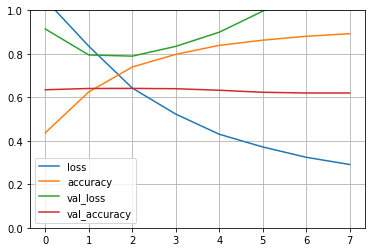

In [41]:
# Plot Accuracy score dan loss value pada data train maupun data validation
pd.DataFrame(model_dnn_hist.history).plot()
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Berdasarkan hasil training model didapat hasil yang sangat *over-fitting*, dimana value accuracy train data terus meningkat dan nampaknya accuracy validation data berkisar 0.6.

Berikutnya kita coba modifikasi model kita sebelumnya, dengan menambahkan BatchNormalization dan mengubah jumlah neuron tiap hidden layers.

Adapun manfaat dari BatchNormalization dikutip dari Ioffe & Szegedy (2015):

*Batch Normalization allows us to use much higher learning rates and
be less careful about initialization. It also acts as a regularizer, in some cases eliminating the need for Dropout.*

Sumber: https://arxiv.org/pdf/1502.03167.pdf

In [42]:
np.random.seed(27)
tf.random.set_seed(42)

model_2 = Sequential()
model_2.add(Dense(20,activation='relu',input_dim=num_vocab,kernel_initializer=tf.keras.initializers.he_normal(seed=27)))
model_2.add(Dropout(0.5))
model_2.add(BatchNormalization())
model_2.add(Dense(20,activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=27)))
model_2.add(Dropout(0.5))
model_2.add(BatchNormalization())
model_2.add(Dense(3,activation='softmax'))

model_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics='accuracy')

In [43]:
model_dnn2_hist = model_2.fit(X_train_tfvec,y_train_ohe,
                         batch_size = 64,
                         epochs=50,
                         callbacks=early_stopping,
                         validation_data=(X_val_tfvec,y_val_ohe))

Epoch 1/50
127/127 [==============================] - 8s 52ms/step - loss: 1.3019 - accuracy: 0.3868 - val_loss: 1.0985 - val_accuracy: 0.3541
Epoch 2/50
127/127 [==============================] - 3s 25ms/step - loss: 1.0722 - accuracy: 0.4660 - val_loss: 1.0882 - val_accuracy: 0.3604
Epoch 3/50
127/127 [==============================] - 3s 26ms/step - loss: 0.9476 - accuracy: 0.5417 - val_loss: 1.0532 - val_accuracy: 0.4652
Epoch 4/50
127/127 [==============================] - 3s 25ms/step - loss: 0.8458 - accuracy: 0.6063 - val_loss: 0.9839 - val_accuracy: 0.5659
Epoch 5/50
127/127 [==============================] - 3s 26ms/step - loss: 0.7582 - accuracy: 0.6663 - val_loss: 0.8962 - val_accuracy: 0.5974
Epoch 6/50
127/127 [==============================] - 3s 25ms/step - loss: 0.6889 - accuracy: 0.7040 - val_loss: 0.8661 - val_accuracy: 0.6111
Epoch 7/50
127/127 [==============================] - 3s 26ms/step - loss: 0.6241 - accuracy: 0.7406 - val_loss: 0.8589 - val_accuracy: 0.6178

In [44]:
tf.keras.backend.clear_session()

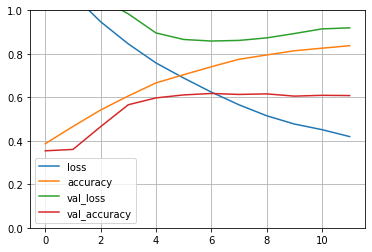

In [45]:
# Plot Accuracy score dan loss value pada data train maupun data validation
pd.DataFrame(model_dnn2_hist.history).plot()
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Hasil yang didapat tidak jauh berbeda dari model sebelumnya, dimana model *over-fiting* dan accuracy validation data tidak beranjak dari 0.6.

In [46]:
# Cek performa pada data test
model_2.evaluate(X_test_tfvec,y_test_ohe)

85/85 [==============================] - 1s 6ms/step - loss: 0.8625 - accuracy: 0.6037


[0.8625338077545166, 0.6037036776542664]

Didapat hasil accuracy yang serupa (dengan hasil validation data) pada data test yakni accuracy score sebesar 0.6. Model ke-2 ini nampaknya tidak memberikan suatu perubahan yang signifikan.

Selanjutnya kita coba pada model dengan menambahkan TextVectorization, Embedding, serta LSTM yang akan dilakukan training dengan data yang masih dalam text. Sama seperti sebelumnya, pada model ini juga diterapkan Droput dan BatchNormalization untuk mencegah kecenderungan *over-fitting* dikarenakan hasil model sebelumnya *over-fitting*.

In [47]:
# Define text_vectorization and Embedding
text_vectorization = TextVectorization(max_tokens=num_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,)
                                       )

text_vectorization.adapt(X_train)

embedding = Embedding(input_dim=num_vocab,
                      output_dim=100,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len
                      )

In [48]:
# Define model with text_vectorization, embedding and LSTM
np.random.seed(27)
tf.random.set_seed(42)

model_3 = Sequential([
    text_vectorization,
    embedding,
    LSTM(32, return_sequences=True),
    LSTM(32),
    Dense(10, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(3, activation='softmax')
])
model_3.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics='accuracy')

In [49]:
model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 715)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 715, 100)          3556100   
                                                                 
 lstm (LSTM)                 (None, 715, 32)           17024     
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 10)                330       
                                                                 
 batch_normalization (BatchN  (None, 10)               40        
 ormalization)                                          

In [50]:
# Train model dengan data train dan validation yang masih dalam bentuk text
model_dnn3_hist = model_3.fit(X_train,y_train_ohe,
                         batch_size = 64,
                         epochs=50,
                         callbacks=early_stopping,
                         validation_data=(X_val,y_val_ohe))

Epoch 1/50
127/127 [==============================] - 134s 1s/step - loss: 1.0986 - accuracy: 0.3337 - val_loss: 1.1445 - val_accuracy: 0.3322
Epoch 2/50
127/127 [==============================] - 129s 1s/step - loss: 1.0989 - accuracy: 0.3316 - val_loss: 1.2262 - val_accuracy: 0.3322
Epoch 3/50
127/127 [==============================] - 128s 1s/step - loss: 1.0996 - accuracy: 0.3360 - val_loss: 4.8382 - val_accuracy: 0.3333
Epoch 4/50
127/127 [==============================] - 129s 1s/step - loss: 1.0987 - accuracy: 0.3378 - val_loss: 3.3469 - val_accuracy: 0.3333
Epoch 5/50
127/127 [==============================] - 128s 1s/step - loss: 1.0988 - accuracy: 0.3246 - val_loss: 1.6772 - val_accuracy: 0.3333
Epoch 6/50
127/127 [==============================] - 128s 1s/step - loss: 1.0987 - accuracy: 0.3407 - val_loss: 2.0399 - val_accuracy: 0.3333


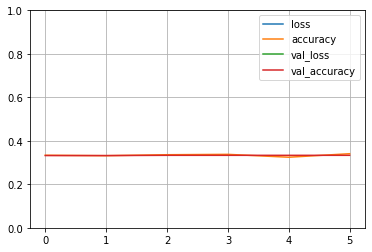

In [51]:
# Plot Accuracy score dan loss value pada data train maupun data validation
pd.DataFrame(model_dnn3_hist.history).plot()
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Berdasarkan hasil training model terlihat val_loss pada validation data tidak berubah, sehingga validation accuracy tetap di value 0.33.

In [52]:
tf.keras.backend.clear_session()

# 8 - Model Evaluation

Pada bagian ini kita coba mengevaluasi kedua model yang sudah kita buat dan modifikasi sebelumnya pada data test dan melihat bagaimana tingkat error prediksi yang dihasilkan.

Pertama kita coba accuracy score dari ketiga model pada data test.

In [53]:
acc_test_1 = model.evaluate(X_test_tfvec,y_test_ohe)
acc_test_2 = model_2.evaluate(X_test_tfvec,y_test_ohe)
acc_test_3 = model_3.evaluate(X_test,y_test_ohe)
print('Loss for model 1:', acc_test_1[0],'with accuracy score:',acc_test_1[1])
print('Loss for model 2:', acc_test_2[0],'with accuracy score:',acc_test_2[1])
print('Loss for model 3 (LSTM):', acc_test_3[0],'with accuracy score:',acc_test_3[1])

85/85 [==============================] - 12s 134ms/step - loss: 1.1437 - accuracy: 0.3333
Loss for model 1: 0.8082619905471802 with accuracy score: 0.631851851940155
Loss for model 2: 0.8625338077545166 with accuracy score: 0.6037036776542664
Loss for model 3 (LSTM): 1.1437431573867798 with accuracy score: 0.3333333432674408


Dari ketiga model yang dibuat, terlihat model pertama memiliki accuracy score yang tertinggi yaitu sekitar 0.63 meskipun masih terbilang rendah. Sedangkan model ketiga memiliki accuracy terendah yaitu 0.33.

Kita dapat mengeluarkan prediction dari ketiga model tersebut dalam bentuk probability target.

In [54]:
# Menghasilkan predict proba pada masing-masing model
y_proba_1 = model.predict(X_test_tfvec)
y_proba_2 = model_2.predict(X_test_tfvec)
y_proba_3 = model_3.predict(X_test)

Disini hasil prediksi ditentukan dengan mengambil probability tertinggi dari ketiga class pada tiap data. Hal tersebut dapat dilakukan dengan function berikut.

In [55]:
# Function untuk menentukan class taret dengan probability tertinggi
def proba_to_pred(y_proba):
  ind = np.argmax(y_proba, axis=1)
  pred = ind - 1 #minus 1 untuk menghasilkan sentiment sesuai yang didefinisikan di awal yaitu -1, 0, dan 1
  return pred

In [56]:
# Hasil prediksi sentiment pada data test

y_pred_1 = proba_to_pred(y_proba_1)
y_pred_2 = proba_to_pred(y_proba_2)
y_pred_3 = proba_to_pred(y_proba_3)

Berikutnya kita akan tampilkan score lainnya seperti precision f1 score dan recall untuk tiap class target dengan classification report sebagai berikut.

In [57]:
print(classification_report(y_test,y_pred_1))

              precision    recall  f1-score   support

          -1       0.68      0.66      0.67       900
           0       0.53      0.57      0.55       900
           1       0.71      0.66      0.68       900

    accuracy                           0.63      2700
   macro avg       0.64      0.63      0.63      2700
weighted avg       0.64      0.63      0.63      2700



Berdasarkan laporan di atas untuk model 1, terlihat cukup baik dalam memprediksi sentiment 1 (positive) dan -1 (negative) berdasarkan score precision, recall dan f1-score yang cukup besar dibanding pada class sentiment 0 (neutral).

Baik precision dan recall tiap class cukup balanced dengan total accuracy keseluruhan 0.63.

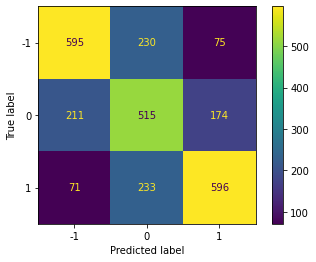

In [58]:
cm_1 = confusion_matrix(y_test, y_pred_1)
ConfusionMatrixDisplay(cm_1,display_labels=[-1,0,1]).plot()

Cukup banyak kelas neutral yang salah prediksi menjadi class positive dan negative. Sedangkan utuk class positive banyak miss prediksi menjadi class neutral, terlihat sejumlah 233 (dari total 900 positive sentiment) sentiment actual positive yang diprediksi menjadi neutral dan 71 sentiment actual positive yang diprediksi menjadi negative. Sama halnya juga dengan sentiment negative yang salah prediksi ke sentiment neutral.

Hal tersebut mungkin bisa dibilang wajar, karena bagi kita manusia sekalipun dalam membaca berbagai neutral review ini bisa jadi kita menganggapnya sebagai positive ataupun negative (tergantung perspektif). Karena bisa jadi banyak vocab yang mencerminkan positive sentiment ataupun negative dalam review netural sentiment. Misalkan 'I think this movie is good enough to watch, good visualitation, great actor but nothing special about the story' dengan rating 6. Dimana sedikit vocab dengan sentiment negative pada kalimat tersebut, sehingga bisa diprediksi oleh model (atau bahkan manusia apabila tidak mengetahui nilai ratingnya) sebagai postive review sentiment.

In [59]:
print(classification_report(y_test,y_pred_2))

              precision    recall  f1-score   support

          -1       0.74      0.52      0.61       900
           0       0.49      0.68      0.57       900
           1       0.67      0.61      0.64       900

    accuracy                           0.60      2700
   macro avg       0.63      0.60      0.61      2700
weighted avg       0.63      0.60      0.61      2700



Sedangkan pada model 2 yang mana modifikasi model 1 sebelumnya terlihat penurunan recall score serta kenaikan precision pada class sentiment -1 dan 1. Dengan kata lain terjadi peningkatan ratio jumlah prediksi yang benar pada sentiment positive dan negative dari jumlah prediksi untuk kedua kelas tersebut.

Namun hal tersebut terjadi berlawanan pada kelas sentiment neutral, dimana terjadi penurunan precision dan kenaikan recall score.

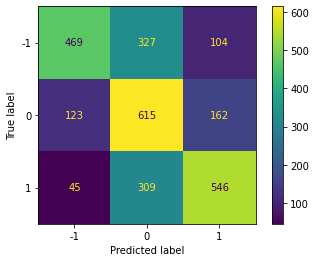

In [60]:
cm_2 = confusion_matrix(y_test, y_pred_2)
ConfusionMatrixDisplay(cm_2,display_labels=[-1,0,1]).plot()

Dari sini kita melihat perbedaan antara model ke-1, dan model ke-2. Dimana model ke-2 terdapat banyak miss prediksi menjadi neutral sentiment. Hal ini dapat dilihat dari contoh :
- 327 sentimen negative (dari 900 total negative sentiment) diprediksi menjadi neutral sentiment. 
- 309 sentimen positive (dari 900 total negative sentiment) diprediksi menjadi neutral sentiment. 

Tidak mengherankan terjadi penurunan recall score baik class negative dan positive sentiment. Dan kenaikan recall sentiment neutral akibat banyak prediksi yang dimasukkan ke neutral sentiment.

Kita coba cek beberapa sentiment aktual postive yang terprediksi menjadi neutral.

In [78]:
print(X_test[(y_test == 1) & (y_pred_2 == 0)].iloc[0])
print(X_test[(y_test == 1) & (y_pred_2 == 0)].iloc[1])

good movie watching movie comedy good acting
excellent surprise honest saw movie picture netflix hero stand balcony selfie stick expected movie survivor posting social medium wrong pretty good zombie movie different perspective decent plot story main deception blockbuster ending enjoy movie expected special opposite


Pada contoh baris pertama terlihat jelas (bagi saya) menyatakan positive sentiment, karena mengandung kata-kata positive 'good'. Namun model ke-2 ini nampaknya masih blm mampu mengenalinya sebagai positive sentiment mungkin karena hanya terdapat dua kata positive yaitu 'good' sehingga model menganggapnya sebagai neutral. Karena bisa jadi dari beberapa contoh neutral sentiment data train mengandung sentiment yang lebih positive dari contoh ini.

Sedangkan pada contoh baris ke dua memang tidak terdapat banyak kata-kata sentiment positive didalamnya, sehingga terjadi salah prediksi ke neutral sentiment oleh model.

In [61]:
print(classification_report(y_test,y_pred_3))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       900
           0       0.00      0.00      0.00       900
           1       0.33      1.00      0.50       900

    accuracy                           0.33      2700
   macro avg       0.11      0.33      0.17      2700
weighted avg       0.11      0.33      0.17      2700



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


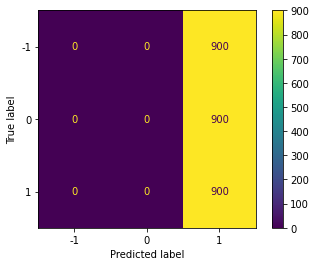

In [62]:
cm_3 = confusion_matrix(y_test, y_pred_3)
ConfusionMatrixDisplay(cm_3,display_labels=[-1,0,1]).plot()

Dapat dilihat model 3 dengan LSTM, dan embedding ini tidak berkeja dengan baik. Model ini sama sekali tidak memberikan prediksi yang tepat pada sentiment positive dan negative, semua data diprediksi menjadi positive sentiment (terkadang bisa menghasilkan semuanya neutral atau negative sentiment untuk dalam berbagai percobaan training).

Saya juga telah mencoba beberapa hal, yang pertama adalah mengganti validation data namun didapatkan hasil yang serupa validation accuracy stuck sekitar 0.3. Lalu saya mencoba train model tanpa membandingkan validation data (hanya melihat data training saja), namun accuracy training pun juga tidak meningkat signifikan hanya berputar di kisaran interval 0.32-0.35 accuracy score. 

Karena proses training dapat berjalan lancar, disini saya asumsikan tidak ada masalah terkait rancangan model ke-3 ini. Salah satu dugaan solusi yang mungkin adalah memperbanyak size data baik train maupun validation.

Berdasarkan penjabaran di atas, menurut saya model terbaik disini adalah model ke-1 dengan mempertimbangkan accuracy score, dan stabilitas recall dan precision class sentiment.

# 9 - Model Saving

Pada proses ini kita akan save proses yang telah kita lakukan dari preprocessing data hingga model prediksi.

Model yang kita simpan memiliki input matrix yang dihasilkan oleh TFidvectorizer yang sudah di-fit pada data train sebagai 'tf_id_vect' yang juga akan kita simpan beserta model sequential ke-1.

In [63]:
with open('preprocess_text.pkl', 'wb') as file_1:
  pickle.dump(tf_idf_vect, file_1)

In [64]:
# freeze model
#model.trainable = False

#Save model
#model.save("review_model")

In [65]:
#! zip -r review_model.zip review_model

  adding: review_model/ (stored 0%)
  adding: review_model/saved_model.pb (deflated 88%)
  adding: review_model/keras_metadata.pb (deflated 87%)
  adding: review_model/assets/ (stored 0%)
  adding: review_model/variables/ (stored 0%)
  adding: review_model/variables/variables.data-00000-of-00001 (deflated 19%)
  adding: review_model/variables/variables.index (deflated 62%)


# 10 - Model Inference

Model yang sudah dilatih akan dicoba pada data yang bukan termasuk ke dalam train-set ataupun test-set, yakni data inference. 

Data yang digunakan dalam inference ini di luar dari file json dari dataset awal. Saya mengambil sebagian 10 sample dari salah satu json file dan menyimpannya dalam csv. Hal ini dikarenakan agar tidak menyita banyak memory dalam load data inference, dibanding load dari salah satu file json.

In [66]:
data_inf = pd.read_csv('inf_data.csv')
data_inf

,Unnamed: 0,review_id,reviewer,movie,rating,review_summary,review_date,spoiler_tag,review_detail,helpful
0,340291,rw0704975,nbarratt,The Matrix Reloaded (2003),5.0,It's been a long time coming...,15 July 2003,0,Trinity falling backwards through the window i...,"['0', '0']"
1,195744,rw0286124,the red duchess,Close-Up (1990),8.0,Almost lives up to his reputation.,8 November 2000,0,This is apparently the most important film of ...,"['9', '18']"
2,274406,rw0631834,avanhame,The Patriot (2000),10.0,Excellent,22 July 2000,0,"After reading the reviews, I felt it necessary...","['13', '20']"
3,83292,rw0156557,dean29,Suspiria (1977),2.0,This movie is not scary,17 August 2002,0,Warning: If you have heard good reviews about...,"['10', '24']"
4,370401,rw0738431,MattPDX,The Trip (2002),10.0,GREAT movie!!!,26 February 2002,0,Miles Swain has directed an excellent movie. T...,"['1', '3']"
5,430648,rw0805812,cscorder,Sakuya: yôkaiden (2000),7.0,Nice Eastern eye candy,8 November 2001,0,Credible action flick even if it's obviously a...,"['1', '1']"
6,123423,rw0202834,isotope2112,The Meaning of Life (1983),5.0,"Funny, but uneven",21 March 2003,0,I just saw The Meaning of Life again recently....,"['0', '5']"
7,296324,rw0656047,FlickJunkie-2,The Omega Code (1999),2.0,Uniformly awful,27 April 2000,0,This film was dreadful in almost every regard....,"['3', '7']"
8,318951,rw0681195,Zar,Maciste il vendicatore dei Maya (1965),3.0,A very weird experience!,6 June 2001,0,The extremely obscure Kirk Morris vehicle MACI...,"['4', '4']"
9,343408,rw0708500,azaro666,The Tailor of Panama (2001),5.0,What did I miss?,25 May 2001,0,"I am still convinced, even now, that I have mi...","['0', '0']"


Kita tentukan terlebih dahulu sentiment berdasarkan rating. Lalu kita terapkan function text preprocessing yang digunakan sebelumnya.

In [67]:
data_inf['sentiment'] = data_inf['rating'].apply(lambda x: rating_sent(x))
data_inf['REVIEW_PROCESSED'] = data_inf['review_detail'].apply(lambda x: text_processing_2(x))

Selanjutnya kita split X dan y pada data inference ini.

In [68]:
X_inf = data_inf['REVIEW_PROCESSED']
y_inf = data_inf.sentiment

Lalu kita transform dengan TfidVectorizer yang sudah kita save sebelumnya.

In [69]:
X_inf_ready = tf_idf_vect.transform(X_inf).toarray()

Untuk target juga diterapkan One-Hot encoding

In [70]:
y_train_ohe = pd.get_dummies(y_inf).values

Selanjutnya kita hasilkan probability, beserta hasil prediksi dari data inference.

In [71]:
y_proba_inf = model.predict(X_inf_ready) # Proba prediction
y_pred_inf = proba_to_pred(y_proba_inf) #Sentiment prediction

In [72]:
#Menampilkan actual dan prediction sentiment dalam DataFrame
pd.DataFrame({'actual_sent':y_inf,'pred_sent':y_pred_inf})

,actual_sent,pred_sent
0,0,-1
1,1,1
2,1,0
3,-1,-1
4,1,1
5,1,0
6,0,0
7,-1,-1
8,-1,0
9,0,0


Dapat kita lihat disini model dapat bekerja baik dengan suatu data inference. Meskipunt terdapat beberapa kesalahan prediksi, namun model dapat memberikan nilai prediksi yang sesuai dimana tidak ada value prediksi diluar nilai -1, 0, dan 1 untuk sembarang input review text.

# 11 - Kesimpulan

Dari dataset yang sudah dilakukan berbagai text processing hingga diinput ke model didapatkan hasil prediksi. Dari ketiga model, didapatkan accuracy terbaik sekitar 0.63 dari sequential model pertama. Accuracy dari model sequential ke-2 tidak jauh berbeda dan sedikit dibawah accuracy model sequential ke-1. Kedua sequential model cenderung *over-fitting* berdasarkan accuracy train yang terus naik sementara accuracy validation tetap di kisaran 0.6, dan tidak terjadi penuruan loss value pada validation data. Dari kedua model memiliki kesamaan terhadap salah prediksi ke neutral sentiment. Nampaknya neutral sentiment ini sulit dibedakan dan menjadi tantangan dalam membedakan sentiment neutral, positive dna negative. Karena bisa jadi banyak kata atau vocab dalam neutral review yang mencerminkan sentiment positive ataupun negative, sehingga banyak terjadi miss klasifikasi. Adapun hal ini bisa terjadi karena pemilihan neutral review yang berdasarkan rating 5 atau 6. Saya menduga proses ini bisa mendapakan accuracy yang lebih baik apabila berurusan dengan binary classification (positive atau negative sentiment) dibanding tiga sentiment dengan neutral sentiment.


Sedangkan model ke-3 dengan Embedding dan LSTM tidak dapat memberikan prediksi yang baik, dimana kesemua input diprediksi sebagai negative sentiment (atau neutral sentiment dalam beberapa trial trainng) sehingga accuracy 0.33. Saya masih tidak tau secara pastinya mengapa hasil model ke-3 bisa seperti ini. Disni telah dicoba dengan validation lain (size yang sama) serta dilakukan training bahkan tanpa validation, tetap tidak membuahkan hasil.

Sentiment analysis prediksi ini mungkin bisa lebih baik menggunakan transfer learning seperti Word2Vec, BERT dsbnya. Namun dalam proses ini menggunakan google colab (free) dimana terdapat limit RAM GPU, dimana sering terjadi crash karena over usage memory. Hal tersebut membuat saya tidak bisa mencoba berbagai transfer learning tersebut. Faktor lain terkait hasil prediksi ini mungkin dari proses text preprocessing. Mungkin terdapat berbagai hal yang perlu di handle dalam text preprocessing, seperti menambahkan stopwords, mencoba stem ataupun lemma lainnya. Selain itu dengan menambahkan size data untuk training dirasa dapat meningkatkan performa. Disini saya menggunakan mengambil sample ukuran kecil, dikarenakan keterbatasan memory maupun storage. Berbagai hal tersebut bisa jadi catatan dalam mengembangkan proses berbagai project terkait sentiment analysis.
